In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Install sentence-transformers for semantic embeddings
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from scipy.sparse import hstack

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [2]:
# Load the data from Kaggle input
data_path = 'train_data.txt'
# Parse the data
records = []
with open(data_path, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split(" ::: ")
        if len(parts) == 4:
            idx, title, genres, plot = parts
            record = {
                "Title": title,
                "Genres": genres,
                "Plot": plot
            }
            # Only accept if Plot and Genre are non-empty
            if record["Plot"] and record["Genres"]:
                records.append(record)

df = pd.DataFrame(records)
print(f"✅ Loaded {len(df)} movie records")
print(f"Sample data:")
print(df.head())


✅ Loaded 54214 movie records
Sample data:
                              Title    Genres  \
0      Oscar et la dame rose (2009)     drama   
1                      Cupid (1997)  thriller   
2  Young, Wild and Wonderful (1980)     adult   
3             The Secret Sin (1915)     drama   
4            The Unrecovered (2007)     drama   

                                                Plot  
0  Listening in to a conversation between his doc...  
1  A brother and sister with a past incestuous re...  
2  As the bus empties the students for their fiel...  
3  To help their unemployed father make ends meet...  
4  The film's title refers not only to the un-rec...  


Dataset shape: (54214, 3)
Columns: ['Title', 'Genres', 'Plot']

Missing values:
Title     0
Genres    0
Plot      0
dtype: int64


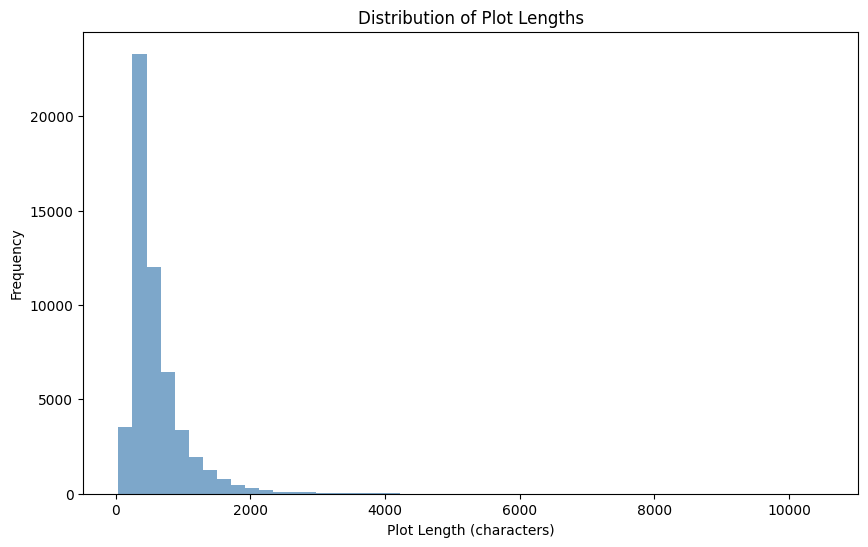

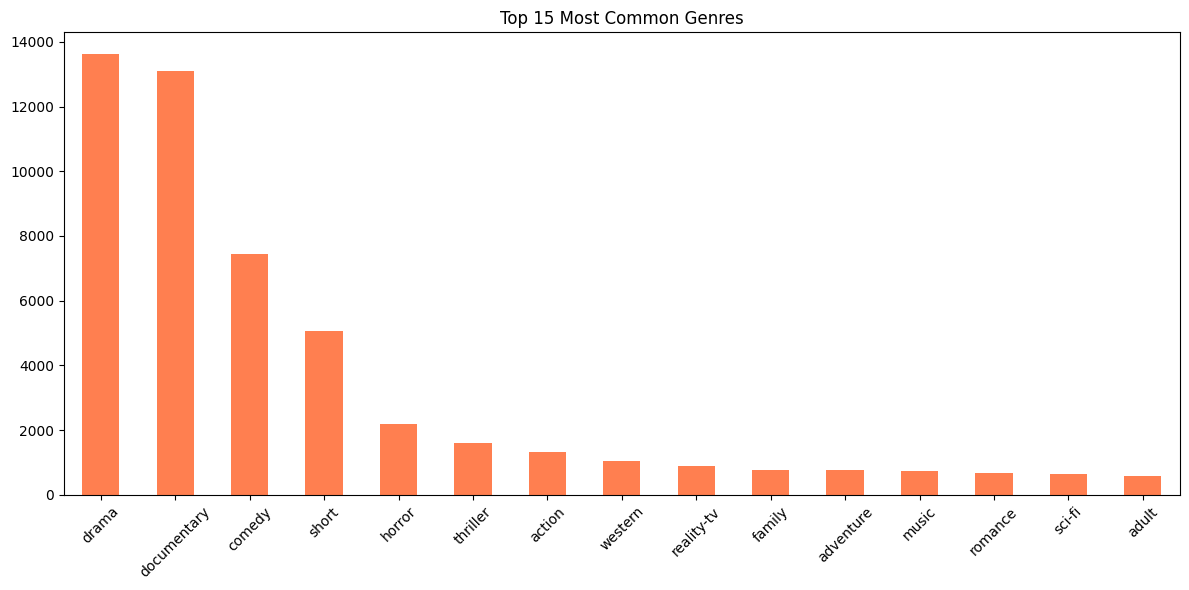

In [3]:
# Basic dataset info
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nMissing values:")
print(df.isnull().sum())

# Plot length distribution
df['plot_length'] = df['Plot'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(df['plot_length'], bins=50, alpha=0.7, color='steelblue')
plt.title('Distribution of Plot Lengths')
plt.xlabel('Plot Length (characters)')
plt.ylabel('Frequency')
plt.show()

# Genre analysis
all_genres = []
for genres in df['Genres']:
    all_genres.extend(genres.split('|'))

genre_counts = pd.Series(all_genres).value_counts().head(15)
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='coral')
plt.title('Top 15 Most Common Genres')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:
# Advanced text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"<[^>]*>", " ", text)  # Remove HTML tags
    text = re.sub(r"[^\w\s]", " ", text)  # Remove special chars
    text = re.sub(r"\s+", " ", text)      # Multiple spaces to single
    return text.lower().strip()

# Apply cleaning
df['Plot_Clean'] = df['Plot'].apply(clean_text)
df = df[df['Plot_Clean'].str.len() > 30].copy()
df['GenreList'] = df['Genres'].str.lower().str.split('|')

print(f"After cleaning: {len(df)} records")
print("Sample cleaned plot:")
print(df['Plot_Clean'].iloc[0][:200] + "...")


After cleaning: 54214 records
Sample cleaned plot:
listening in to a conversation between his doctor and parents 10 year old oscar learns what nobody has the courage to tell him he only has a few weeks to live furious he refuses to speak to anyone exc...


🎯 Training on 54214 samples with 27 genres
Selected genres: ['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'game-show', 'history', 'horror', 'music', 'musical', 'mystery', 'news', 'reality-tv', 'romance', 'sci-fi', 'short', 'sport', 'talk-show', 'thriller', 'war', 'western']

Genre counts:
  action: 1315
  adult: 590
  adventure: 775
  animation: 498
  biography: 265
  comedy: 7447
  crime: 505
  documentary: 13096
  drama: 13613
  family: 784
  fantasy: 323
  game-show: 194
  history: 243
  horror: 2204
  music: 731
  musical: 277
  mystery: 319
  news: 181
  reality-tv: 884
  romance: 672
  sci-fi: 647
  short: 5073
  sport: 432
  talk-show: 391
  thriller: 1591
  war: 132
  western: 1032


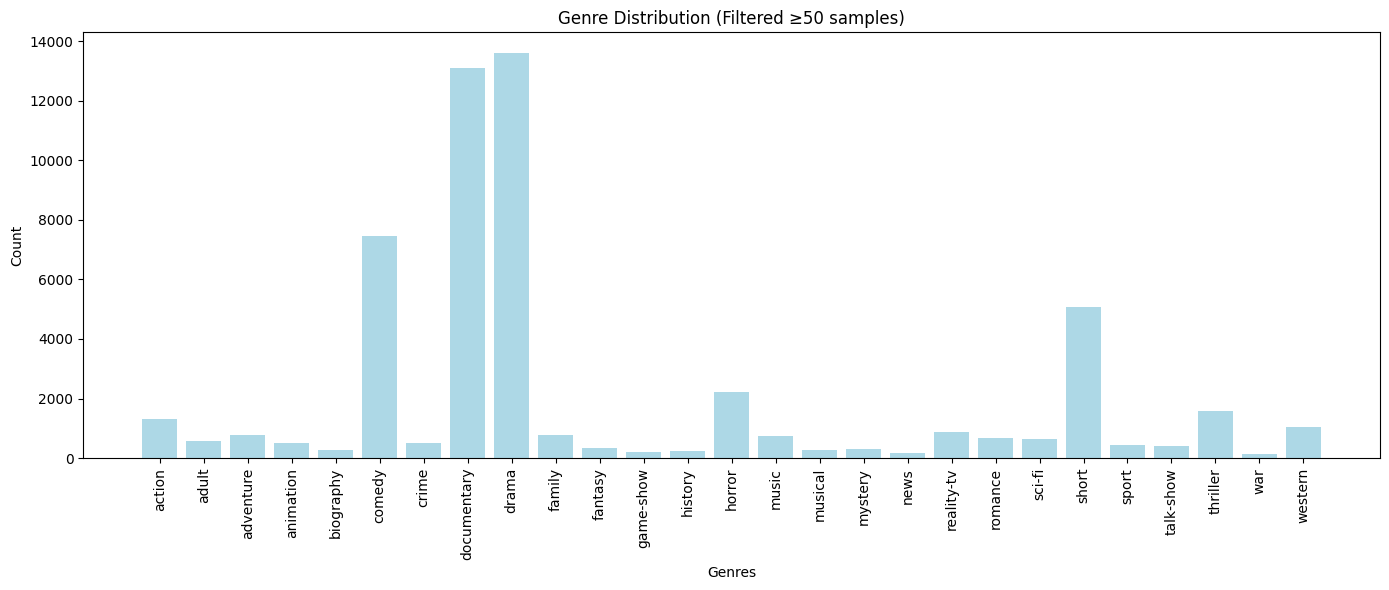

✅ Multi-label setup complete with 27 genres


In [5]:
# Multi-label encoding
mlb = MultiLabelBinarizer()
Y_all = mlb.fit_transform(df['GenreList'])
genre_counts = Y_all.sum(axis=0)
valid_idx = np.where(genre_counts >= 50)[0]  # Filter rare genres
Y = Y_all[:, valid_idx]

# FIX: Extract individual genre names properly
genres = [mlb.classes_[i] for i in valid_idx]

print(f"🎯 Training on {len(df)} samples with {len(genres)} genres")
print(f"Selected genres: {genres}")

# Display genre counts for verification
filtered_counts = genre_counts[valid_idx]
print(f"\nGenre counts:")
for genre, count in zip(genres, filtered_counts):
    print(f"  {genre}: {count}")

# Genre distribution visualization - FIXED
plt.figure(figsize=(14, 6))
plt.bar(range(len(genres)), filtered_counts, color='lightblue')
plt.title('Genre Distribution (Filtered ≥50 samples)')
plt.xlabel('Genres')
plt.xticks(range(len(genres)), genres, rotation=90)  # This should work now
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print(f"✅ Multi-label setup complete with {len(genres)} genres")


In [6]:
# Load transformer model
print("Loading MiniLM transformer model...")
transformer_model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to compute embeddings in batches
def encode_texts(texts, model, batch_size=64):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Computing embeddings"):
        batch = texts[i:i+batch_size]
        emb = model.encode(batch, convert_to_numpy=True, show_progress_bar=False)
        embeddings.append(emb)
    return np.vstack(embeddings)

# Compute transformer embeddings
print("🔄 Computing transformer embeddings...")
X_emb = encode_texts(df['Plot_Clean'].tolist(), transformer_model, batch_size=64)
print(f"✅ Embeddings shape: {X_emb.shape}")


Loading MiniLM transformer model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🔄 Computing transformer embeddings...


Computing embeddings: 100%|██████████| 848/848 [01:37<00:00,  8.69it/s]


✅ Embeddings shape: (54214, 384)


In [7]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words='english',
    min_df=5,
    max_df=0.9,
    sublinear_tf=True
)

print("🔄 Computing TF-IDF features...")
X_tfidf = tfidf.fit_transform(df['Plot_Clean'])
print(f"✅ TF-IDF shape: {X_tfidf.shape}")

# Combine features: TF-IDF + Transformer embeddings
X_features = hstack([X_tfidf, X_emb])
print(f"✅ Combined features shape: {X_features.shape}")


🔄 Computing TF-IDF features...
✅ TF-IDF shape: (54214, 5000)
✅ Combined features shape: (54214, 5384)


In [8]:
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_features, Y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Define classifiers
lgbm = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=250,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)

logreg = LogisticRegression(solver='liblinear', max_iter=500)

# Multi-label OneVsRest classifiers
print("Training LightGBM multi-label model...")
ovr_lgbm = OneVsRestClassifier(lgbm, n_jobs=-1)
ovr_lgbm.fit(X_train, y_train)

print("Training Logistic Regression multi-label model...")
ovr_logreg = OneVsRestClassifier(logreg, n_jobs=-1)
ovr_logreg.fit(X_train, y_train)

print("Models trained successfully!")


Training set: (43371, 5384)
Validation set: (10843, 5384)
Training LightGBM multi-label model...
Training Logistic Regression multi-label model...
Models trained successfully!


In [9]:
# Ensemble prediction function
def ensemble_predict_proba(X):
    proba_lgbm = ovr_lgbm.predict_proba(X)
    proba_logreg = ovr_logreg.predict_proba(X)
    return (proba_lgbm + proba_logreg) / 2

# Make predictions
proba_val = ensemble_predict_proba(X_val)
y_pred = (proba_val >= 0.3).astype(int)  # threshold tunable

# Evaluation metrics
print("EVALUATION RESULTS:")
print("=" * 50)
print(classification_report(y_val, y_pred, target_names=genres))


EVALUATION RESULTS:
              precision    recall  f1-score   support

      action       0.61      0.25      0.36       263
       adult       0.75      0.40      0.52       112
   adventure       0.32      0.09      0.14       139
   animation       0.23      0.05      0.08       104
   biography       0.00      0.00      0.00        61
      comedy       0.59      0.60      0.60      1443
       crime       0.36      0.04      0.07       107
 documentary       0.72      0.85      0.78      2659
       drama       0.57      0.76      0.65      2697
      family       0.47      0.09      0.16       150
     fantasy       0.50      0.01      0.03        74
   game-show       0.81      0.55      0.66        40
     history       0.00      0.00      0.00        45
      horror       0.72      0.59      0.65       431
       music       0.66      0.55      0.60       144
     musical       0.25      0.02      0.04        50
     mystery       0.14      0.02      0.03        56
       

In [15]:
# Test with sample plots
sample_plots = [
    "A young wizard attends a magical school and battles dark forces threatening the world.",
    "Two people from different backgrounds fall in love despite overwhelming obstacles.",
    "A documentary exploring the wildlife and ecosystems of the Amazon rainforest.",
    "A criminal detective investigates a series of crimes in a small industrial town, goes on a hunt to find who the criminal is."
]

print("SAMPLE PREDICTIONS:")
print("=" * 50)

for i, plot in enumerate(sample_plots, 1):
    # Preprocess
    clean_plot = clean_text(plot)
    plot_tfidf = tfidf.transform([clean_plot])
    plot_emb = transformer_model.encode([clean_plot], convert_to_numpy=True)
    plot_features = hstack([plot_tfidf, plot_emb])

    # Predict
    proba = ensemble_predict_proba(plot_features)[0]
    threshold = 0.3
    pred_indices = np.where(proba >= threshold)[0] # <-- Extract the indices array here

    pred_genres = [genres[i] for i in pred_indices]
    confidences = proba[pred_indices]

    print(f"\n{i}. Plot: {plot}")
    print(f"   Predicted Genres: {', '.join(pred_genres)}")
    print(f"   Confidences: {[f'{c:.2f}' for c in confidences]}")


SAMPLE PREDICTIONS:

1. Plot: A young wizard attends a magical school and battles dark forces threatening the world.
   Predicted Genres: drama
   Confidences: ['0.33']

2. Plot: Two people from different backgrounds fall in love despite overwhelming obstacles.
   Predicted Genres: drama, romance
   Confidences: ['0.52', '0.42']

3. Plot: A documentary exploring the wildlife and ecosystems of the Amazon rainforest.
   Predicted Genres: documentary
   Confidences: ['0.93']

4. Plot: A criminal detective investigates a series of crimes in a small industrial town, goes on a hunt to find who the criminal is.
   Predicted Genres: 
   Confidences: []


In [16]:
import pickle

# Save all required components for the Streamlit app
components_to_save = {
    'tfidf_vectorizer': tfidf,
    'transformer_model': transformer_model,
    'ovr_lgbm': ovr_lgbm,
    'ovr_logreg': ovr_logreg,
    'genres': genres,
    'clean_text_func': clean_text  # We'll need to recreate this function
}

# Save to pickle file
with open('movie_genre_classifier.pkl', 'wb') as f:
    pickle.dump(components_to_save, f)

print("✅ All components saved to 'movie_genre_classifier.pkl'")

# Also save individual components for easier loading
import joblib
joblib.dump(ovr_lgbm, 'lgbm_model.pkl')
joblib.dump(ovr_logreg, 'logreg_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("✅ Individual components also saved!")


✅ All components saved to 'movie_genre_classifier.pkl'
✅ Individual components also saved!
